# Input Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm
import optuna
import random

In [ ]:
data = pd.read_csv('FPT raw.csv')
#Tham số chính
BATCHSIZE = 64
WINDOWSIZE = 30
FORECASTHORIZON = 3
INPUTSIZE = 164

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

class StockDataProcessor:
    def __init__(self, data, company_name, lookback=WINDOWSIZE, forecast_horizon=FORECASTHORIZON,
                 val_ratio=0.1, test_ratio=0.1, batch_size=BATCHSIZE):
        self.data = data
        self.company_name = company_name
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.batch_size = batch_size

        # Xử lý dữ liệu
        self._process_data()

    def _process_data(self):
        """Pipeline xử lý dữ liệu an toàn không bị leakage"""
        self._prepare_raw_data()
        self._split_raw_data()  # Chia dữ liệu thô trước tiên
        self._initialize_scalers()  # Khởi tạo scaler chỉ trên train
        self._scale_data()  # Scale riêng từng tập
        self._create_sequences()  # Tạo sequences riêng cho từng tập
        self._create_dataloaders()

    def _prepare_raw_data(self):
        """Tách features và target từ dữ liệu gốc"""
        self.X_raw = self.data.drop(columns=[f'Close_{self.company_name}', 'Date']).values
        self.y_raw = self.data[f'Close_{self.company_name}'].values

    def _split_raw_data(self):
        """Chia dữ liệu thô thành train/val/test theo thời gian"""
        n_samples = len(self.X_raw)
        train_end = int(n_samples * (1 - self.val_ratio - self.test_ratio))
        val_end = int(n_samples * (1 - self.test_ratio))

        # Chia X và y thành các tập riêng biệt
        self.X_train_raw = self.X_raw[:train_end]
        self.y_train_raw = self.y_raw[:train_end]
        self.X_val_raw = self.X_raw[train_end:val_end]
        self.y_val_raw = self.y_raw[train_end:val_end]
        self.X_test_raw = self.X_raw[val_end:]
        self.y_test_raw = self.y_raw[val_end:]

    def _initialize_scalers(self):
        """Khởi tạo scaler và chỉ fit trên tập train"""
        self.x_scaler = StandardScaler()
        self.x_scaler.fit(self.X_train_raw)  # Chỉ học tham số từ train

        self.y_scaler = Pipeline([
            ('minmax', MinMaxScaler())
        ])
        self.y_scaler.fit(self.y_train_raw.reshape(-1, 1))  # Chỉ học tham số từ train

    def _scale_data(self):
        """Áp dụng scaling riêng cho từng tập"""
        self.X_train = self.x_scaler.transform(self.X_train_raw)
        self.X_val = self.x_scaler.transform(self.X_val_raw)
        self.X_test = self.x_scaler.transform(self.X_test_raw)

        self.y_train = self.y_scaler.transform(self.y_train_raw.reshape(-1, 1)).flatten()
        self.y_val = self.y_scaler.transform(self.y_val_raw.reshape(-1, 1)).flatten()
        self.y_test = self.y_scaler.transform(self.y_test_raw.reshape(-1, 1)).flatten()

    def _create_sequences(self):
        """Tạo sequences cửa sổ trượt cho từng tập riêng biệt"""
        def create_sequences(X, y):
            X_seq, y_seq = [], []
            for i in range(self.lookback, len(X)):
                X_seq.append(X[i-self.lookback:i])
                y_seq.append(y[i])
            return np.array(X_seq), np.array(y_seq)

        self.X_train_seq, self.y_train_seq = create_sequences(self.X_train, self.y_train)
        self.X_val_seq, self.y_val_seq = create_sequences(self.X_val, self.y_val)
        self.X_test_seq, self.y_test_seq = create_sequences(self.X_test, self.y_test)

    def _create_dataloaders(self):
        """Tạo DataLoaders từ tensor"""
        train_data = TensorDataset(
            torch.FloatTensor(self.X_train_seq),
            torch.FloatTensor(self.y_train_seq))

        val_data = TensorDataset(
            torch.FloatTensor(self.X_val_seq),
            torch.FloatTensor(self.y_val_seq))

        test_data = TensorDataset(
            torch.FloatTensor(self.X_test_seq),
            torch.FloatTensor(self.y_test_seq))

        self.train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True,  pin_memory=True)
        self.val_loader = DataLoader(val_data, batch_size=self.batch_size, shuffle=False, pin_memory=True)
        self.test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False, pin_memory=True)

    def inverse_transform_y(self, y):
        """Chuyển đổi y đã scaled về giá trị gốc"""
        return self.y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()

In [ ]:
train_loader = StockDataProcessor(data, 'FPT').train_loader
val_loader = StockDataProcessor(data, 'FPT').val_loader
test_loader = StockDataProcessor(data, 'FPT').test_loader

# LSTM

In [ ]:
class GaussianNoise(nn.Module):
    """Lớp Gaussian Noise với cơ chế decay tự động"""
    def __init__(self, std=0.1, decay_factor=0.97):
        super().__init__()
        self.std = std
        self.current_std = std
        self.decay_factor = decay_factor

    def decay(self):
        """Giảm cường độ nhiễu sau mỗi epoch"""
        self.current_std = max(self.current_std * self.decay_factor, 0.01)

    def forward(self, x):
        if self.training and self.current_std > 0:
            return x + torch.randn_like(x) * self.current_std
        return x

In [ ]:
#Attention 1
class FeatureAttention(nn.Module):
    def __init__(self, dim, reduction_ratio=4):
        super().__init__()
        reduced_dim = max(dim // reduction_ratio, 16)

        self.attn = nn.Sequential(
            nn.Linear(dim, reduced_dim),
            nn.SiLU(),
            nn.Linear(reduced_dim, dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.attn(x)

In [ ]:
#Attention 2
class MultiScaleTemporal(nn.Module):
    def __init__(self, input_dim, hidden_dim, scales):
        super().__init__()
        self.scales = scales
        n_scales = len(scales)
        per_scale, remainder = divmod(hidden_dim, n_scales)
        self.conv_dims = [per_scale + (1 if i < remainder else 0) for i in range(n_scales)]
        self.convs = nn.ModuleList([
            nn.Conv1d(input_dim, dim, kernel_size=k, padding=k//2)
            for k, dim in zip(scales, self.conv_dims)
        ])
        self.weights = nn.Parameter(torch.ones(len(scales)))

    def forward(self, x):
        x_t = x.transpose(1, 2)
        scale_features = []
        for conv in self.convs:
            conv_out = conv(x_t).transpose(1, 2)
            scale_features.append(conv_out)

        weights = F.softmax(self.weights, dim=0)
        fused = torch.cat([w*feat for w, feat in zip(weights, scale_features)], dim=-1)
        return torch.cat([fused, x], dim=-1)

In [ ]:
class HierarchicalLSTM(nn.Module):
    def __init__(self, n_features=INPUTSIZE, hidden_dim=64, num_layers=2, window_size=WINDOWSIZE, dropout_rate = 0.3):
        super().__init__()
        self.window_size = window_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # ========== Feature Extraction Level ==========
        self.input_noise = GaussianNoise(std=0.02)
        self.feature_noise = GaussianNoise(std=0.02)

        # Feature selector with dynamic dimension handling
        self.feature_selector = nn.Sequential(
            nn.Linear(n_features, hidden_dim),
            nn.SiLU(),
            nn.BatchNorm1d(window_size),
            FeatureAttention(hidden_dim),
            nn.Dropout(0.3)
        )

        # ========== Temporal Processing Level ==========
        self.lstm_noise = GaussianNoise(std=0.02)
        # LSTM with layer normalization and proper parameter handling
        self.lstm = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            bidirectional=True,
            num_layers=self.num_layers,
            dropout=self.dropout_rate if self.num_layers > 1 else 0,  # Set dropout to 0 if num_layers = 1
            batch_first=True
        )

        # Layer norm for LSTM outputs (per layer if needed)
        self.lstm_layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim * 2) for _ in range(num_layers)
        ])
        # ========== Attention with Residual ==========

        num_heads = max(2, hidden_dim // 64)
        embed_dim = (hidden_dim * 2 // num_heads) * num_heads

        self.attn_noise = GaussianNoise(std=0.02)
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=0.2,
            batch_first=True
        )
        self.attn_residual = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim)
        )

        # ========== Multi-Scale Processing ==========
        self.scale_noise = GaussianNoise(std=0.02)
        self.temporal_scaler = MultiScaleTemporal(
            input_dim=hidden_dim*2,
            hidden_dim=hidden_dim,
            scales=[3, 7, 21, 45]
        )

        # ========== Output Level ==========
        output_expansion = 6
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim*output_expansion, hidden_dim*2),
            nn.Mish(),
            nn.LayerNorm(hidden_dim*2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim*2, 1),
        )

    def forward(self, x):
        # Input processing
        x = self.input_noise(x)
        features = self.feature_noise(self.feature_selector(x))

        # LSTM processing with layer norms
        lstm_out, _ = self.lstm(self.lstm_noise(features))
        # Apply layer norms if multiple layers
        if self.num_layers > 1:
            lstm_out = self.lstm_layer_norms[-1](lstm_out)
        else:
            lstm_out = lstm_out

        # Attention processing
        attn_out, _ = self.attention(
            self.attn_noise(lstm_out),
            lstm_out,
            lstm_out
        )
        attn_out = attn_out + self.attn_residual(lstm_out)

        # Multi-scale processing
        fused = self.temporal_scaler(self.scale_noise(attn_out))

        # Pooling and output
        mean_pool = fused.mean(dim=1)
        max_pool = fused.max(dim=1).values
        pooled = torch.cat([mean_pool, max_pool], dim=-1)

        return self.output_layer(pooled)

    def decay_noise(self):
        for module in self.modules():
            if isinstance(module, GaussianNoise):
                module.std *= 0.95

# Train

In [ ]:
class Train:
    def __init__(self, model, train_loader, val_loader,
                 trial=None,
                 learning_rate=1e-4,
                 weight_decay=1e-5,
                 epochs=50,
                 early_stopping_patience=10,
                 grad_clip=1.0,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 pct_start=0.3,
                 amp_enabled=True,
                 device=None,
                 scaler_y=None):  # NEW: chuẩn hóa đầu ra
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.trial = trial
        self.scaler_y = scaler_y

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.early_stopping_patience = early_stopping_patience
        self.grad_clip = grad_clip
        self.betas = betas
        self.eps = eps
        self.pct_start = pct_start
        self.amp_enabled = amp_enabled

        self._init_components()
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')

    def _init_components(self):
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
            betas=self.betas,
            eps=self.eps
        )
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.learning_rate,
            steps_per_epoch=len(self.train_loader),
            epochs=self.epochs,
            pct_start=self.pct_start
        )

        from torch.amp import GradScaler
        self.scaler = GradScaler(enabled=self.amp_enabled and self.device.type == 'cuda')
        self.early_stopping_counter = 0

    def _train_epoch(self):
        self.model.train()
        running_loss = 0.0

        for X, y in self.train_loader:
            X, y = X.to(self.device), y.to(self.device)

            if self.scaler_y:
                y = self.scaler_y.transform(y.cpu().numpy()).astype(np.float32)
                y = torch.tensor(y).to(self.device)

            self.optimizer.zero_grad()

            with torch.autocast(device_type='cuda', enabled=self.amp_enabled):
                preds = self.model(X)
                y = y.unsqueeze(1)
                loss = self.loss_fn(preds, y)

            self.scaler.scale(loss).backward()

            if self.grad_clip:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)

            self.scaler.step(self.optimizer)
            self.scaler.update()

            running_loss += loss.item()

        self.scheduler.step()

        avg_loss = running_loss / len(self.train_loader)
        self.train_losses.append(avg_loss)
        return avg_loss


    def _validate(self):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)

                if self.scaler_y:
                    y = self.scaler_y.transform(y.cpu().numpy()).astype(np.float32)
                    y = torch.tensor(y).to(self.device)

                with torch.autocast(device_type='cuda', enabled=self.amp_enabled):
                    preds = self.model(X)
                    y = y.unsqueeze(1)
                    loss = self.loss_fn(preds, y)

                total_loss += loss.item()

        avg_loss = total_loss / len(self.val_loader)
        self.val_losses.append(avg_loss)
        return avg_loss

    def train(self):
        try:
            for epoch in range(self.epochs):
                train_loss = self._train_epoch()
                val_loss = self._validate()

                print(f"[Epoch {epoch+1}/{self.epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

                if self.trial:
                    self.trial.report(val_loss, epoch)
                    if self.trial.should_prune():
                        raise optuna.exceptions.TrialPruned()

                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    torch.save(self.model.state_dict(), 'best_model.pth')
                    self.early_stopping_counter = 0
                else:
                    self.early_stopping_counter += 1
                    if self.early_stopping_counter >= self.early_stopping_patience:
                        print("Early stopping triggered.")
                        break

            return self.best_val_loss

        except Exception as e:
            print(f"Training interrupted: {str(e)}")
            return float('inf')



def objective(trial):
    # ===== PHẦN QUAN TRỌNG: CỐ ĐỊNH SEED =====
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # 1. TỐI ƯU THAM SỐ MODEL
    model_params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256, 512]),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.05)
    }

    # 2. TỐI ƯU THAM SỐ TRAINING
    training_params = {
        'learning_rate': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3),
        'grad_clip': trial.suggest_float('grad_clip', 0.5, 2.0),
        'pct_start': trial.suggest_float('pct_start', 0.1, 0.5)
    }

    # 3. KHỞI TẠO MODEL - GIỐNG HỆT KHI TRAIN THẬT
    model = HierarchicalLSTM(**model_params)

    # 4. TRAINER VỚI CẤU HÌNH CỐ ĐỊNH
    trainer = Train(
        model=model,
        train_loader=train_loader,  # Đảm bảo shuffle=True
        val_loader=val_loader,      # shuffle=False
        trial=trial,
        epochs=50,                  # Cố định
        early_stopping_patience=10,  # Cố định
        amp_enabled=True,            # Giống khi train thật
        **training_params
    )

    # 5. QUY TRÌNH ĐÁNH GIÁ NHẤT QUÁN
    val_loss = trainer.train()

    # Lưu lại model tạm thời cho mỗi trial
    torch.save(model.state_dict(), f"temp_model_{trial.number}.pth")
    return val_loss

# HÀM TRAIN THẬT SAU KHI CÓ BEST PARAMS
def train_final_model(best_params):
    torch.manual_seed(42)
    np.random.seed(42)

    model = HierarchicalLSTM(
        hidden_dim=best_params['hidden_dim'],
        num_layers=best_params['num_layers'],
        dropout_rate=best_params['dropout_rate']
    )

    trainer = Train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=best_params['lr'],
        weight_decay=best_params['weight_decay'],
        grad_clip=best_params['grad_clip'],
        pct_start=best_params['pct_start'],
        epochs=50,
        early_stopping_patience=10,
        amp_enabled=True
    )

    trainer.train()
    model.load_state_dict(torch.load('best_model.pth'))
    val_loss = trainer._validate()  # Đánh giá lại mô hình tốt nhất
    return val_loss


In [ ]:
# Quá trình tối ưu hóa
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=3600)

[I 2025-05-02 17:43:31,266] A new study created in memory with name: no-name-ceebfdac-8d1b-4781-a1d8-4783b916022c


[Epoch 1/50] Train Loss: 0.445744 | Val Loss: 0.941372
[Epoch 2/50] Train Loss: 0.369238 | Val Loss: 0.764212
[Epoch 3/50] Train Loss: 0.341981 | Val Loss: 0.642220
[Epoch 4/50] Train Loss: 0.308825 | Val Loss: 0.660187
[Epoch 5/50] Train Loss: 0.306255 | Val Loss: 0.621460
[Epoch 6/50] Train Loss: 0.306175 | Val Loss: 0.494445
[Epoch 7/50] Train Loss: 0.315001 | Val Loss: 0.446081
[Epoch 8/50] Train Loss: 0.276796 | Val Loss: 0.492185
[Epoch 9/50] Train Loss: 0.265547 | Val Loss: 0.457298
[Epoch 10/50] Train Loss: 0.260666 | Val Loss: 0.413610
[Epoch 11/50] Train Loss: 0.249724 | Val Loss: 0.394389
[Epoch 12/50] Train Loss: 0.242359 | Val Loss: 0.407543
[Epoch 13/50] Train Loss: 0.230623 | Val Loss: 0.406674
[Epoch 14/50] Train Loss: 0.209714 | Val Loss: 0.426736
[Epoch 15/50] Train Loss: 0.219269 | Val Loss: 0.397403
[Epoch 16/50] Train Loss: 0.216901 | Val Loss: 0.333152
[Epoch 17/50] Train Loss: 0.194560 | Val Loss: 0.350285
[Epoch 18/50] Train Loss: 0.181973 | Val Loss: 0.338276
[

[I 2025-05-02 17:44:05,665] Trial 0 finished with value: 0.18926253612153232 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_rate': 0.4, 'lr': 2.0450032099403e-05, 'weight_decay': 7.472239257967608e-05, 'grad_clip': 0.6905750489629703, 'pct_start': 0.2727363110007798}. Best is trial 0 with value: 0.18926253612153232.


[Epoch 50/50] Train Loss: 0.045308 | Val Loss: 0.190857
[Epoch 1/50] Train Loss: 0.278180 | Val Loss: 0.308565
[Epoch 2/50] Train Loss: 0.044037 | Val Loss: 0.154673
[Epoch 3/50] Train Loss: 0.020518 | Val Loss: 0.077521
[Epoch 4/50] Train Loss: 0.015142 | Val Loss: 0.081439
[Epoch 5/50] Train Loss: 0.011838 | Val Loss: 0.135743
[Epoch 6/50] Train Loss: 0.010027 | Val Loss: 0.125158
[Epoch 7/50] Train Loss: 0.008733 | Val Loss: 0.082415
[Epoch 8/50] Train Loss: 0.008077 | Val Loss: 0.043289
[Epoch 9/50] Train Loss: 0.006395 | Val Loss: 0.073973
[Epoch 10/50] Train Loss: 0.005724 | Val Loss: 0.083572
[Epoch 11/50] Train Loss: 0.004988 | Val Loss: 0.127244
[Epoch 12/50] Train Loss: 0.004585 | Val Loss: 0.066027
[Epoch 13/50] Train Loss: 0.004333 | Val Loss: 0.058172
[Epoch 14/50] Train Loss: 0.003936 | Val Loss: 0.085870
[Epoch 15/50] Train Loss: 0.004618 | Val Loss: 0.084480
[Epoch 16/50] Train Loss: 0.005387 | Val Loss: 0.113447
[Epoch 17/50] Train Loss: 0.005494 | Val Loss: 0.120864


[I 2025-05-02 17:44:13,062] Trial 1 finished with value: 0.04328936726475755 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_rate': 0.35, 'lr': 0.00791645290424174, 'weight_decay': 0.0006454178804132294, 'grad_clip': 1.9350567994923291, 'pct_start': 0.4572506122991463}. Best is trial 1 with value: 0.04328936726475755.


[Epoch 18/50] Train Loss: 0.004384 | Val Loss: 0.091848
Early stopping triggered.
[Epoch 1/50] Train Loss: 0.500777 | Val Loss: 1.093339
[Epoch 2/50] Train Loss: 0.368617 | Val Loss: 1.112862
[Epoch 3/50] Train Loss: 0.320688 | Val Loss: 0.834218
[Epoch 4/50] Train Loss: 0.304044 | Val Loss: 0.844548
[Epoch 5/50] Train Loss: 0.284627 | Val Loss: 0.956875
[Epoch 6/50] Train Loss: 0.258150 | Val Loss: 0.782721
[Epoch 7/50] Train Loss: 0.222982 | Val Loss: 0.582608
[Epoch 8/50] Train Loss: 0.206219 | Val Loss: 0.817071
[Epoch 9/50] Train Loss: 0.181410 | Val Loss: 0.583618
[Epoch 10/50] Train Loss: 0.177558 | Val Loss: 0.599756
[Epoch 11/50] Train Loss: 0.151488 | Val Loss: 0.522909
[Epoch 12/50] Train Loss: 0.138849 | Val Loss: 0.644069
[Epoch 13/50] Train Loss: 0.123336 | Val Loss: 0.473896
[Epoch 14/50] Train Loss: 0.109017 | Val Loss: 0.476038
[Epoch 15/50] Train Loss: 0.114687 | Val Loss: 0.418067
[Epoch 16/50] Train Loss: 0.098570 | Val Loss: 0.361214
[Epoch 17/50] Train Loss: 0.084

In [ ]:
# Huấn luyện với tham số tốt nhất
best_params = study.best_params
print(best_params)

{'hidden_dim': 512, 'num_layers': 2, 'dropout_rate': 0.4, 'lr': 0.0057884400610284225, 'weight_decay': 0.0007812995996557225, 'grad_clip': 1.630526095524147, 'pct_start': 0.4438474504619236}


In [ ]:
final_model = HierarchicalLSTM(
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout_rate=best_params['dropout_rate']
)

final_trainer = Train(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=best_params['lr'],
    weight_decay=best_params['weight_decay'],
    grad_clip=best_params['grad_clip'],
    pct_start=best_params['pct_start'],
    early_stopping_patience=best_params.get('patience', 15),
    amp_enabled=True,
    epochs=50
)

final_val_loss = final_trainer.train()


[Epoch 1/50] Train Loss: 27.908347 | Val Loss: 1.383071
[Epoch 2/50] Train Loss: 0.628546 | Val Loss: 0.558287
[Epoch 3/50] Train Loss: 0.129627 | Val Loss: 0.386981
[Epoch 4/50] Train Loss: 0.064111 | Val Loss: 0.267118
[Epoch 5/50] Train Loss: 0.041675 | Val Loss: 0.344208
[Epoch 6/50] Train Loss: 0.031689 | Val Loss: 0.147258
[Epoch 7/50] Train Loss: 0.025030 | Val Loss: 0.176549
[Epoch 8/50] Train Loss: 0.021576 | Val Loss: 0.110645
[Epoch 9/50] Train Loss: 0.018257 | Val Loss: 0.235784
[Epoch 10/50] Train Loss: 0.016862 | Val Loss: 0.102276
[Epoch 11/50] Train Loss: 0.014821 | Val Loss: 0.113697
[Epoch 12/50] Train Loss: 0.010578 | Val Loss: 0.083696
[Epoch 13/50] Train Loss: 0.010836 | Val Loss: 0.080468
[Epoch 14/50] Train Loss: 0.008897 | Val Loss: 0.079980
[Epoch 15/50] Train Loss: 0.008175 | Val Loss: 0.083915
[Epoch 16/50] Train Loss: 0.007264 | Val Loss: 0.105725
[Epoch 17/50] Train Loss: 0.006398 | Val Loss: 0.129690
[Epoch 18/50] Train Loss: 0.006009 | Val Loss: 0.088239


In [ ]:
print(best_params)

# Model Evaluation

RMSE: 22.9073
MAE: 19.7818
R2: -0.8297


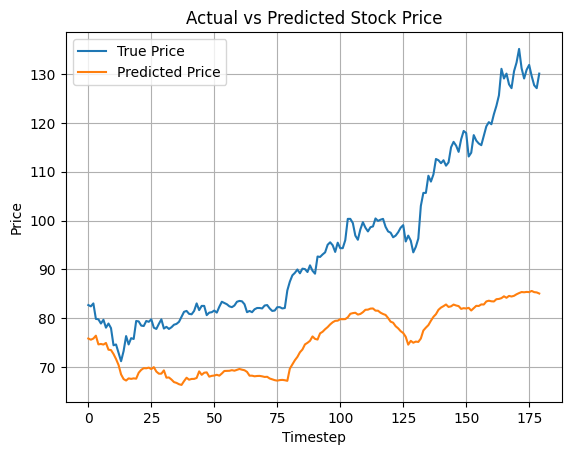

22.90726148799912 19.781802749633787 -0.829710416567421


In [ ]:
def evaluate_model(model, X_test, y_test, scaler_X, scaler_Y, forecast_horizon, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    model.to(device)
    X_test = X_test.reshape(-1, WINDOWSIZE, model.feature_selector[0].in_features)

    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
        preds = model(X_test_tensor).cpu().numpy()

    # Đảo ngược chuẩn hóa
    preds_inv = scaler_Y.inverse_transform(preds.reshape(-1, 1))  # (n_samples, 1)
    y_test_inv = scaler_Y.inverse_transform(y_test.reshape(-1, 1))  # (n_samples, 1)

    # Đánh giá trực tiếp trên từng bước dự báo (không tính trung bình ngày)
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    r2 = r2_score(y_test_inv, preds_inv)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")

    # Vẽ đồ thị
    plt.plot(y_test_inv, label='True Price')
    plt.plot(preds_inv, label='Predicted Price')
    plt.title('Actual vs Predicted Stock Price')
    plt.xlabel('Timestep')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    return rmse, mae, r2


x_val_scaled = StockDataProcessor(data, 'FPT').X_val_seq
y_val_scaled = StockDataProcessor(data, 'FPT').y_val_seq
scaler_x = StockDataProcessor(data, 'FPT').x_scaler
scaler_y = StockDataProcessor(data, 'FPT').y_scaler

rmse, mae, r2 = evaluate_model(final_model, x_val_scaled, y_val_scaled, scaler_x, scaler_y, FORECASTHORIZON)
print(rmse, mae, r2)